In [2]:
import numpy as np
import json
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')


In [4]:
def chunkify(lst, n):
    """Split a list into chunks of size n."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

def reduce(machine_texts, human_texts):
    # Step 1: Determine the number of duplications
    num_duplications = len(machine_texts) // len(human_texts)

    # Step 2: Duplicate the human texts
    expanded_human_texts = human_texts * num_duplications

    # Step 3: Sample the remaining number of human texts if needed
    remaining_texts_needed = len(machine_texts) - len(expanded_human_texts)
    expanded_human_texts += random.sample(human_texts, remaining_texts_needed)

    # Step 4: Merge and shuffle the lists
    print("human: " + str(len(expanded_human_texts)) + " mahcine: " + str(len(machine_texts)))
    balanced_texts = expanded_human_texts + machine_texts
    random.shuffle(balanced_texts)
    
    return balanced_texts

def get_all_label(array):
    # Plot the histogram of the data
    plt.hist(array, bins=len(array), edgecolor='black')
    plt.title('Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.6)

    plt.show()

# def get_machine_text_model(machine_texts, human_tests): 
    # machine_texts_model = [[] for i in range(8)]    
    # for item in machine_texts: 
    #     if "model" in item:
    #         machine_texts_model[int(item["model"]) + 1].append(item)

    # machine_texts_model[o0]
        
    # return machine_texts_model

def equalize_subarray_lengths(arr_2d):
    # 1. Find the length of the longest sub-array.
    max_length = max(len(sub_array) for sub_array in arr_2d)
    
    # 2. Modify each sub-array to have the same length as the longest one.
    for i in range(len(arr_2d)):
        while len(arr_2d[i]) < max_length:
            # Duplicate elements to make the lengths match.
            diff = max_length - len(arr_2d[i])
            arr_2d[i].extend(arr_2d[i][:diff])
    return arr_2d

def random_sampling(machine_texts, human_texts, seed=None): 
    if seed:
        random.seed()
        
    machine_texts_model = [[] for i in range(7)]
    
    number_each_model = len(human_texts) // 7
    
    for item in machine_texts: 
        if "model" in item:
            machine_texts_model[int(item["model"])].append(item)
    
    machine_texts_sampling = []
    for model in machine_texts_model:
        selected = random.sample(model, number_each_model)
        machine_texts_sampling += selected
    
    remaining_texts_needed = len(human_texts) - len(machine_texts_sampling)
    machine_texts_sampling += random.sample(model, remaining_texts_needed)    
    
    return machine_texts_sampling + human_texts

def random_sampling_model(machine_texts, human_texts, model): 
    
    machine_texts_model = [[] for i in range(7)]
    for item in machine_texts: 
        # print(item)
        # break
        if "model" in item:
            # print(item)
            machine_texts_model[int(item["model"])].append(item)
    
    return random.sample(machine_texts_model[model], len(human_texts)) + human_texts


8


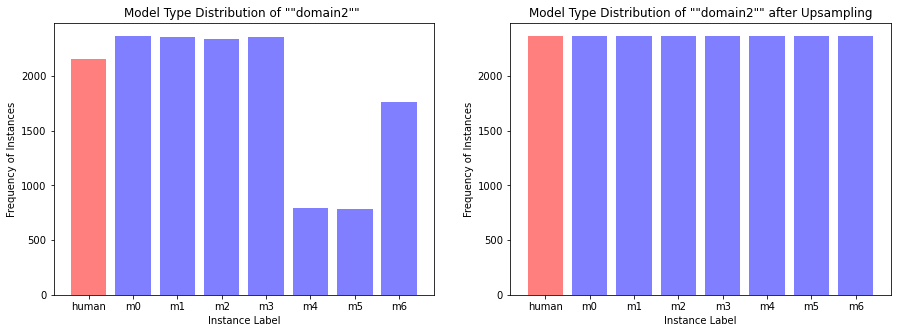

In [5]:
plt.rcParams['figure.dpi'] = 200  # or any other desired value

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

train_data_2_machine_per_model = [[] for _ in range(8)]

with open('domain2_train.json', 'r') as file:
    for line in file:
        data = json.loads(line)
        if data["label"] == 0: 
           train_data_2_machine_per_model[int(data["model"]) + 1].append(data)
        else:
            train_data_2_machine_per_model[0].append(data)

frequencies = [len(sub_list) for sub_list in train_data_2_machine_per_model]
names = ['human', 'm0', 'm1', 'm2', 'm3', 'm4', 'm5' , 'm6']
colors = ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']
ax1.bar(names, frequencies, color=colors, alpha=0.5)
ax1.set_xlabel('Instance Label')
ax1.set_ylabel('Frequency of Instances')
ax1.set_title('Model Type Distribution of ""domain2"" ')

print(len(train_data_2_machine_per_model))
train_data_2_machine_per_model_e = equalize_subarray_lengths(train_data_2_machine_per_model)


import matplotlib.pyplot as plt

# Calculate the frequencies
frequencies = [len(sub_list) for sub_list in train_data_2_machine_per_model_e]

# Create the histogram
ax2.bar(names, frequencies, color=colors, alpha=0.5)
ax2.set_xlabel('Instance Label')
ax2.set_ylabel('Frequency of Instances')
ax2.set_title('Model Type Distribution of ""domain2"" after Upsampling')

# ax2.title('Histogram of 2D array based on number of elements in each sub-array')

plt.show()

In [15]:
vectorizer = CountVectorizer(ngram_range=(1,2))


train_data_1 = []

with open('domain1_train.json', 'r') as file:
    for line in file:
        data = json.loads(line)
        train_data_1.append(data)

k = 3  # Number of folds
kf = KFold(n_splits=k)


scores = []
models = []

for train_index, val_index in kf.split(train_data_2_machine_per_model[0]):
    
    train_all  = []
    val_all = []

    train_all  += train_data_1 # add train 1
    # print(f"model train after add domain1: {len(train_all)}")
    train_all += train_data_2_machine_per_model[0]
    
    # print(f"model train after add more human: {len(train_all)}")

    for i in [1,3,4]:
    
                
        train_x = np.array(train_data_2_machine_per_model[i])
        train, val = train_x[train_index], train_x[val_index]
        
        train_all += train.tolist() # add train 2
        val_all += val.tolist()
    

    print(f"model train: {len(train_all)} val: {len(val_all)}")
    
    # break

    logistic_model = LogisticRegression(max_iter=1000)
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
    grid_search = GridSearchCV(logistic_model, param_grid, cv=10)
  
    
    X_train = np.array([entry["text"] for entry in train_all])
    y_train = np.array([entry["label"] for entry in train_all])
    X_test = np.array([entry["text"] for entry in val_all])
    y_test = np.array([entry["label"] for entry in val_all])
    
    X_train_text = [' '.join(map(str, sample)) for sample in X_train]
    X_test_text = [' '.join(map(str, sample)) for sample in X_test]
        
    X_train_transformed = vectorizer.fit_transform(X_train_text)
    X_test_transformed = vectorizer.transform(X_test_text)    
    
    grid_search.fit(X_train_transformed, y_train)    
    best_model = grid_search.best_estimator_

    models.append(best_model)
    
    y_pred = best_model.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    
    y_pred_train = best_model.predict(X_train_transformed)
    accuracy_trian = accuracy_score(y_train, y_pred_train)

    print(f"Fold: {len(models)}, Val Accuracy: {accuracy:.4f}, Train Accuracy: {accuracy_trian: .4f}")
    
    # break

print(f"\nAverage Accuracy: {np.mean(scores):.4f}")


model train: 26592 val: 2364
Fold: 1, Val Accuracy: 0.6607, Train Accuracy:  0.9995
model train: 26592 val: 2364
Fold: 2, Val Accuracy: 0.6933, Train Accuracy:  0.9996
model train: 26592 val: 2364
Fold: 3, Val Accuracy: 0.7030, Train Accuracy:  0.9978

Average Accuracy: nan


In [13]:
selected_model = models[2]

with open('logistic_output_cross_validation.csv', 'w') as output_file:
    output_file.write('id,class\n')  

    # read in dataset
    with open('test_set.json', 'r') as file:
        for line in file:
            entry = json.loads(line)
            text = entry["text"]

            # word embedding
            X_test = vectorizer.transform([" ".join(map(str, text))])

            # use logistic model to predict
            prediction = best_model.predict(X_test)

            # output csv
            output_file.write(f"{entry['id']},{prediction[0]}\n")

IndexError: list index out of range